In [1]:
import re
from nltk.corpus import stopwords as nltk_stop_words
from nltk.tokenize import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install pymysql

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tarek.mehrez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/tarek.mehrez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def process_text(text):
    tokens = word_tokenize(text)
    tokens_cleaned = [re.sub(r'\W+', '', re.sub(r'\b\d+[.,]?\d*\b', '0', token.lower()))
                      for token in tokens
                      if token.isalnum() and 
                      token not in nltk_stop_words.words('english')]
    return tokens_cleaned

In [5]:
import pymysql
mydb = pymysql.connect(
  host="172.17.12.101",
  user="root",
  passwd="wehatenews",
  database="news"
)
cur = mydb.cursor()
cur.execute("select reddit_title from uplifting_news")
good_titles = cur.fetchall()

cur = mydb.cursor()
cur.execute("select reddit_title from feelbadnews")
feelbad_titles = cur.fetchall()

cur = mydb.cursor()
cur.execute("select reddit_title from politics")
politics = cur.fetchall()

cur = mydb.cursor()
cur.execute("select title from crimes")
crimes = cur.fetchall()

In [6]:
from random import shuffle

good_titles = [process_text(title[0]) for title in good_titles]
crimes = [process_text(title[0]) for title in crimes]
politics = [process_text(title[0]) for title in politics]
feelbad_titles = [process_text(title[0]) for title in feelbad_titles]

all_bad = politics 
shuffle(all_bad)
all_titles = good_titles + all_bad[:600]

good_bad_dict = {}


for idx, _ in enumerate(all_titles):
    if idx <= len(good_titles) - 1:
        good_bad_dict[idx] = 'good'
    else:
        good_bad_dict[idx] = 'bad'

In [7]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_titles)]


In [19]:
model = Doc2Vec(documents, vector_size=50, window=5, min_count=1, workers=10, epochs=200)
vectors = [model[i] for i, _ in enumerate(all_titles)]

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(vectors)

In [21]:
df = pd.DataFrame(X_tsne, index=list(range(len(documents))), columns=['x', 'y'])

In [22]:
cols=[]
for idx, _ in enumerate(vectors):
    if good_bad_dict[idx] == 'good':
        cols.append('green')
    else:
        cols.append('red')

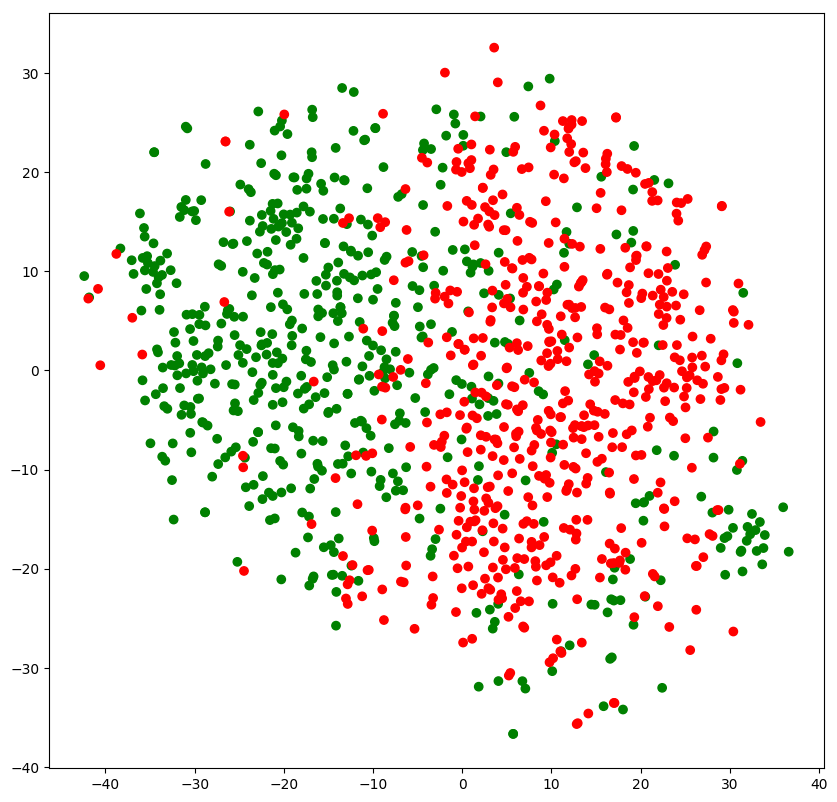

In [23]:
plt.figure(figsize=(10,10), dpi=100)
plt.scatter(df['x'], df['y'],c=cols)

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

clf = SVC(gamma='scale')


X = vectors
Y = [1 if (idx < len(good_titles)) else 0 for idx, _ in enumerate(X)]

cv = ShuffleSplit(n_splits=10, test_size=0.2)
cross_val_score(clf, X, Y, cv=cv)



array([0.89361702, 0.86382979, 0.91489362, 0.86808511, 0.9106383 ,
       0.90638298, 0.87659574, 0.8893617 , 0.88085106, 0.87234043])